In [109]:
from pathlib import Path

is_colab = False  # if run in colab set this true

In [111]:
# setup the environment


if is_colab:

  from google.colab import drive
  drive.mount('/content/gdrive')
  
  path_root = Path('/content/gdrive/My Drive/Colab Notebooks/')
  
  # install the pynvcenter package from github
  !pip install git+https://github.com/JanGieseler/pynvcenter.git
    
    
    
  from keras import backend as K
  print(K.tensorflow_backend._get_available_gpus())
else:
  path_root = Path('../')
  
  # for the local version we assume that pynvcenter is located in the parent dir of the notebook
  import os,sys,inspect
  currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
  parentdir = os.path.dirname(currentdir)
  sys.path.insert(0,parentdir) 

path_ipynb = path_root/'notebooks'
path_data = path_root/'data'
path_model = path_root/'models'
path_html = path_root/'html'

PosixPath('../html')

In [112]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

import pynvcenter.nv_analysis as nv_analysis

from sklearn.externals import joblib

import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from keras import optimizers
from sklearn.metrics import mean_squared_error
from keras.callbacks import Callback
from sklearn.externals import joblib
import h5py
from keras import regularizers

from sklearn.model_selection import learning_curve

from keras.callbacks import EarlyStopping, ModelCheckpoint
import time

import matplotlib.pyplot as plt


from matplotlib.patches import Rectangle

%matplotlib inline

from tqdm import tqdm

import h5py
%load_ext autoreload
%autoreload 2
from keras.models import load_model

from glob import glob

import matplotlib 

from IPython.display import display, Markdown

FONT_SIZE = 20
matplotlib.rc('xtick', labelsize=FONT_SIZE) 
matplotlib.rc('ytick', labelsize=FONT_SIZE) 
matplotlib.rc('axes', titlesize=FONT_SIZE) 
matplotlib.rc('axes', labelsize=FONT_SIZE) 
matplotlib.rc('lines', linewidth=2) 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [113]:
from pynvcenter.nn_utils import *

### show the experimental data
#### define inputs (filenames, calibration, etc.)

In [87]:
# filename_esr = '../data_exp/190122-15_41_20_esr_many_on_alice_wider_range_center_0_0_esr_map.h5'
# filename_pos = '../data_exp/190122-15_40_40_select_points'


filename_pos = '../data_exp/190123-19_32_44_select_points'

filename_esr = '../data_exp/190123-19_39_47_esr_many_on_alice_wider_range_center_0_0'




freq_center = 2870000000.0
freq_range = 500000000.0


calibration_factor = 200/162 * 267 / 0.5  # mu / px * px / V = mu / V

particle_radius = 19  # um

print('the calibration factor is {:0.3f} micrometers / volt'.format(calibration_factor))

h5f = h5py.File(filename_esr+'_esr_map.h5', 'r')
esr_map = np.array(h5f['esr_map'])
frequencies = np.array(h5f['frequency'])
h5f.close()
print('frequencies from {:0.3f}GHz - {:0.3f}GHz'.format(1e-9*(freq_center-freq_range/2), 1e-9*((freq_center+freq_range/2))))

the calibration factor is 659.259 micrometers / volt
frequencies from 2.620GHz - 3.120GHz


[300.  240.   67.5 277.5  45.  270.  150.   75.  262.5   0.  105.   52.5
 247.5 210.  120.  142.5 202.5 180.   15.   22.5  60.  345.  337.5 330.
  90.  292.5 135.   30.  157.5 127.5  97.5 285.  112.5 322.5   7.5 165.
 195.  315.   37.5 172.5 255.  352.5 217.5 187.5 225.   82.5 307.5 232.5]


**esr radius:	 67.067 micrometers**

image dimensions:  (48, 448)


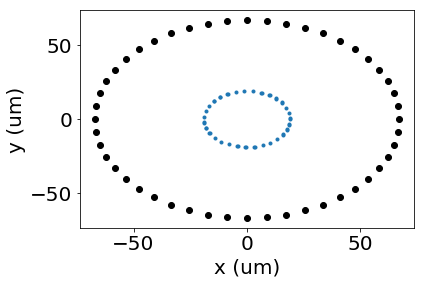

In [89]:
nv_positions = calibration_factor * np.genfromtxt(filename_pos+ '-nv_locations.csv', delimiter=',')[1:]  # positions in um
angles = np.genfromtxt(filename_pos+ '-angles.csv', delimiter=',')[1:]  # angles in rad

nv_positions -=np.mean(nv_positions, axis=0)  # center around zero 
nv_positions, angles = nv_positions[angles.argsort()], angles[angles.argsort()] # sort
for pos in nv_positions:
    plt.plot(pos[0], pos[1], 'ko')
    
# angles = np.linspace(0, 360, esr_map.shape[0])
plt.plot(particle_radius*np.cos(angles), particle_radius*np.sin(angles), '.')

radius  = np.mean(np.sqrt(np.sum(nv_positions**2, axis=1)))
display(Markdown('**esr radius:\t {:0.3f} micrometers**'.format(radius)))
plt.xlabel('x (um)')
plt.ylabel('y (um)')

print('image dimensions: ', esr_map.shape)

In [85]:
noise_region = {'fmin':2.65e9, 'f_range':1e8, 'angle_min':50, 'angle_range':150}

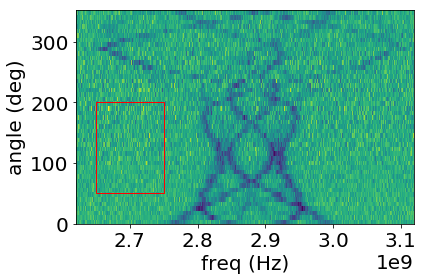

In [86]:
# angles = np.linspace(0, 360, esr_map.shape[0])
fig, ax = plt.subplots(1, 1, figsize=(6, 4))


ax.pcolor(frequencies, angles, esr_map)

# Create a Rectangle patch
rect = Rectangle((noise_region['fmin'],noise_region['angle_min']),
                 noise_region['f_range'],noise_region['angle_range'],linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

ax.set_ylabel('angle (deg)')
ax.set_xlabel('freq (Hz)')
# ax.set_title('theta = {:0.0f}, phi={:0.0f}'.format(theta_mag, phi_mag))
plt.tight_layout()

### Look at the noise

The noise is $n = \sqrt{c \tau}$, where $s = c \tau$ are the number of photons collected. Thus, the normalized noise is

$$n_{\rm norm} = n/s =  1 / \sqrt{c \tau}$$,

where $c$ is the count rate and $\tau$ the measurement time.

**noise: 0.34%**

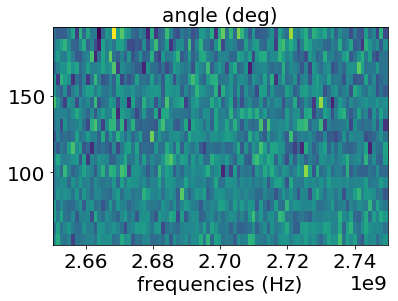

In [102]:
freq_select = np.array(frequencies>noise_region['fmin']) & np.array(frequencies<noise_region['fmin']+noise_region['f_range'])
angle_select = np.array(angles>noise_region['angle_min']) & np.array(angles<noise_region['angle_min']+noise_region['angle_range'])

noise = esr_map[angle_select][:,freq_select]
plt.pcolor(frequencies[freq_select], angles[angle_select], noise)
plt.title('noise')
plt.xlabel('frequencies (Hz)')
plt.title('angle (deg)')
display(Markdown('**noise: {:0.2f}%**'.format(noise.std() / noise.mean() * 100)))


0.044067625631213136

### look at the distributions and get SNR

0.044067625631213136


**SNR: 13**

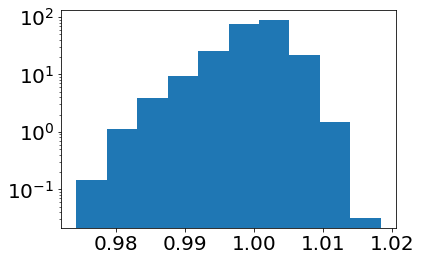

In [104]:
signal = esr_map.max() - esr_map.min()
print(signal)
display(Markdown('**SNR: {:0.0f}**'.format(signal / noise.std())))
plt.hist(esr_map.flatten(), density=True, log=True);

### fit model

**show available models**

In [114]:
# [f.split('/')[-1].split('_model.h5')[0] for f in glob('../models/*model*.h5')]
list(path_model.glob('*_model*'))

[PosixPath('../models/shot_noise_0_xyztp_model.h5')]

## load the model

In [115]:
model_name = 'shot_noise_0_xyztp_model.h5'

In [117]:
model = load_model(str(path_model/model_name))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 46, 446, 64)       640       
_________________________________________________________________
activation_43 (Activation)   (None, 46, 446, 64)       0         
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 23, 223, 64)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 21, 221, 128)      73856     
_________________________________________________________________
activation_44 (Activation)   (None, 21, 221, 128)      0         
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 10, 110, 128)      0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 8, 108, 256)       295168    
__________

In [118]:
# load the scaler
x_scaler = joblib.load(str(path_model/model_name).replace('_model.h5', '_x_scaler.save'))  
y_scaler = joblib.load(str(path_model/model_name).replace('_model.h5', '_y_scaler.save')) 

In [124]:
# load the labels
with open(str(path_model/model_name).replace('_model.h5', '_labels.txt'),"r") as filein:
    labels = filein.read().split(',')
labels

['xo', 'yo', 'dipole_height', 'theta_mag', 'phi_mag']

### show how well model fits on simulated data

In [125]:
magnet_parameters

{'particle_radius': 19,
 'nv_radius': 67,
 'theta_mag': 0,
 'phi_mag': 60,
 'dipole_height': 80,
 'shot_noise': 0,
 'linewidth': 10000000.0,
 'n_angle': 48,
 'n_freq': 448,
 'f_min': 2620000000.0,
 'f_max': 3120000000.0,
 'avrg_count_rate': 1}

In [126]:
n_max = 5

magnet_parameters_new = {**magnet_parameters, 'particle_radius': 18}

print('genrate validation set')
val_set = generate_data(n_max, n_jobs=3, parameters={**magnet_parameters, 'particle_radius': 18})


noise = 0.02*np.random.randn(*val_set['X'].shape)
Xo = val_set['X'][0:n_max]+noise
Yo = val_set['Y']

Xo = esr_preprocessing(Xo)

print(Xo.min(), Xo.max())

  0%|          | 0/5 [00:00<?, ?it/s]

genrate validation set


100%|██████████| 5/5 [00:00<00:00, 25.10it/s]


-0.10620875001457097 0.19947846252565749


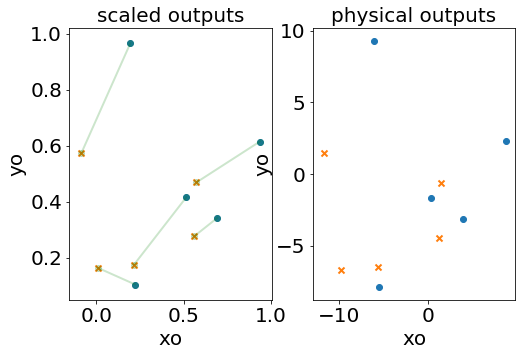

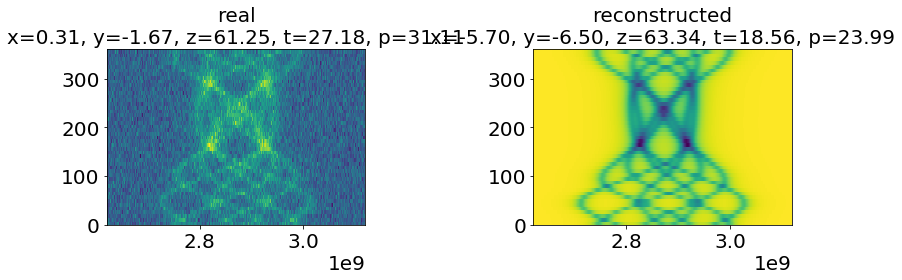

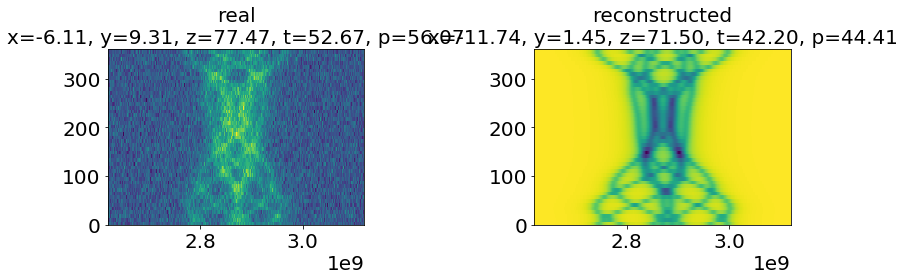

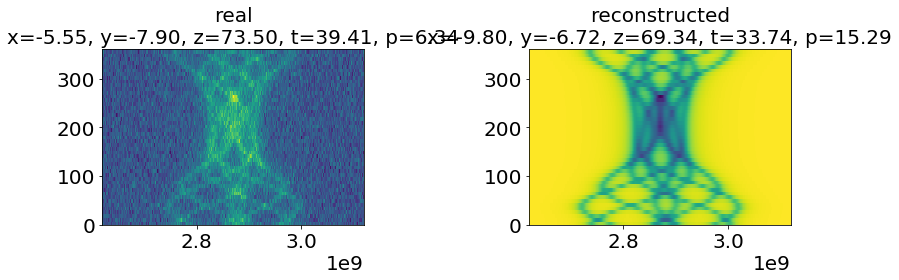

In [128]:
analyze_fit(Xo, Yo, model=model, magnet_parameters=magnet_parameters_new,labels=labels, n_max = n_max,
            x_scaler=x_scaler, y_scaler=y_scaler)

### make prediction for the data

(-0.018397090258050808, 0.02567053537316233)

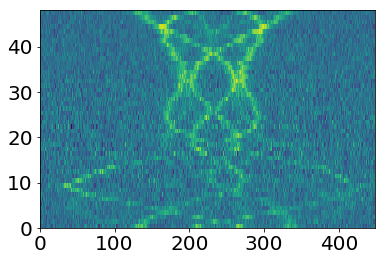

In [202]:
Xo = esr_preprocessing(np.expand_dims(esr_map, axis=0))
Xo = np.flip(Xo, axis=1)  # flip the image upside down
plt.pcolor(Xo[0])
Xo[0].min(), Xo[0].max()

(0.14355081, 0.32498577)

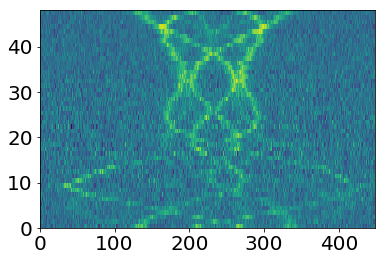

In [203]:
x_shape = Xo.shape
Xs = x_scaler.transform(Xo.reshape(x_shape[0], -1).astype(np.float32)).reshape(x_shape)
plt.pcolor(Xs[0])
Xs[0].min(), Xs[0].max()

In [204]:
esr_y_pred = model.predict(np.expand_dims(Xs, axis=-1))
esr_y_pred

array([[0.64326894, 0.5036489 , 0.88319635, 0.29864562, 0.34184837]],
      dtype=float32)

In [205]:
esr_y_pred_real = y_scaler.inverse_transform(esr_y_pred)

In [206]:
magnet_parameters

{'particle_radius': 19,
 'nv_radius': 67,
 'theta_mag': 0,
 'phi_mag': 60,
 'dipole_height': 80,
 'shot_noise': 0,
 'linewidth': 10000000.0,
 'n_angle': 48,
 'n_freq': 448,
 'f_min': 2620000000.0,
 'f_max': 3120000000.0,
 'avrg_count_rate': 1}

In [185]:
esr_y_pred_real[0,4]=45
esr_y_pred_real[0,3]=54

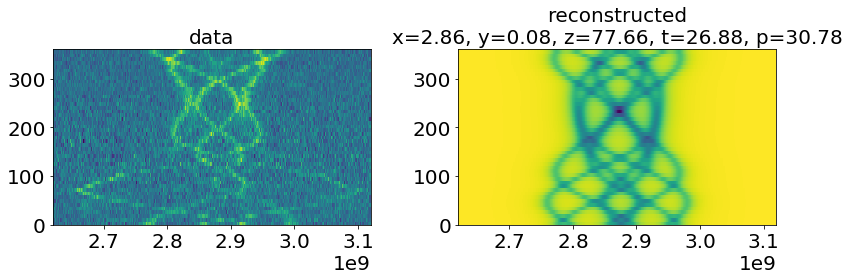

In [208]:
f_min = magnet_parameters['f_min']
f_max = magnet_parameters['f_max']
n_angle = magnet_parameters['n_angle']
n_freq = magnet_parameters['n_freq']
frequencies = np.linspace(f_min, f_max, n_freq)
angle = np.linspace(0, 360, n_angle)


fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].pcolor(frequencies, angle, np.squeeze(Xo[0]))
ax[0].set_title('data')
# and create the image, construction in second argument constructs the updates parameter dictionary
img = create_image(*esr_y_pred_real[0, 0:2],
                   **{**magnet_parameters, **{k: v for k, v in zip(labels[2:], esr_y_pred_real[0, 2:])}})
ax[1].pcolor(frequencies, angle, img)
ax[1].set_title(
    'reconstructed\n' + ', '.join([label_map[k] + '={:0.2f}' for k in labels]).format(*esr_y_pred_real[0]))
plt.tight_layout()

In [209]:
magnet_parameters

{'particle_radius': 19,
 'nv_radius': 67,
 'theta_mag': 0,
 'phi_mag': 60,
 'dipole_height': 80,
 'shot_noise': 0,
 'linewidth': 10000000.0,
 'n_angle': 48,
 'n_freq': 448,
 'f_min': 2620000000.0,
 'f_max': 3120000000.0,
 'avrg_count_rate': 1}

In [215]:
df = pd.DataFrame(3 * (np.random.random((20, 2)) - 0.5), columns=['xo', 'yo'])

In [217]:
df

""
0
1
2
3
4
5
6
7
8
9
